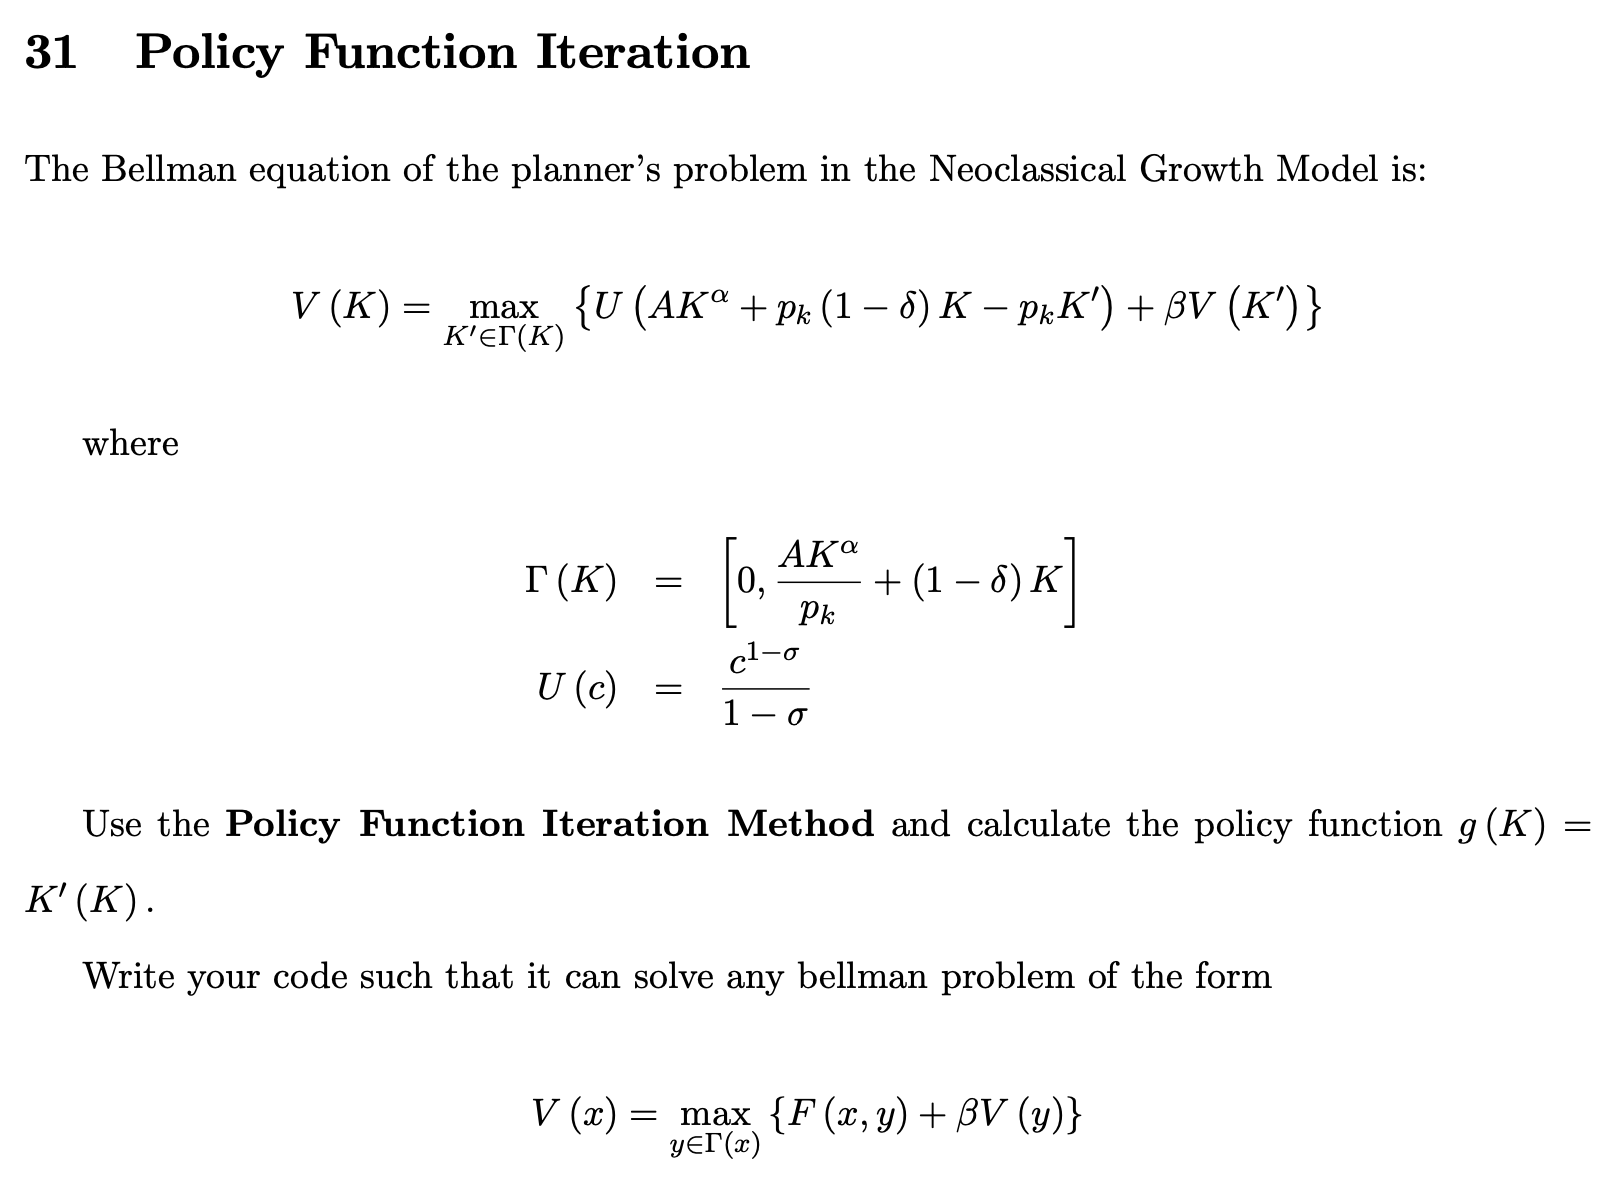

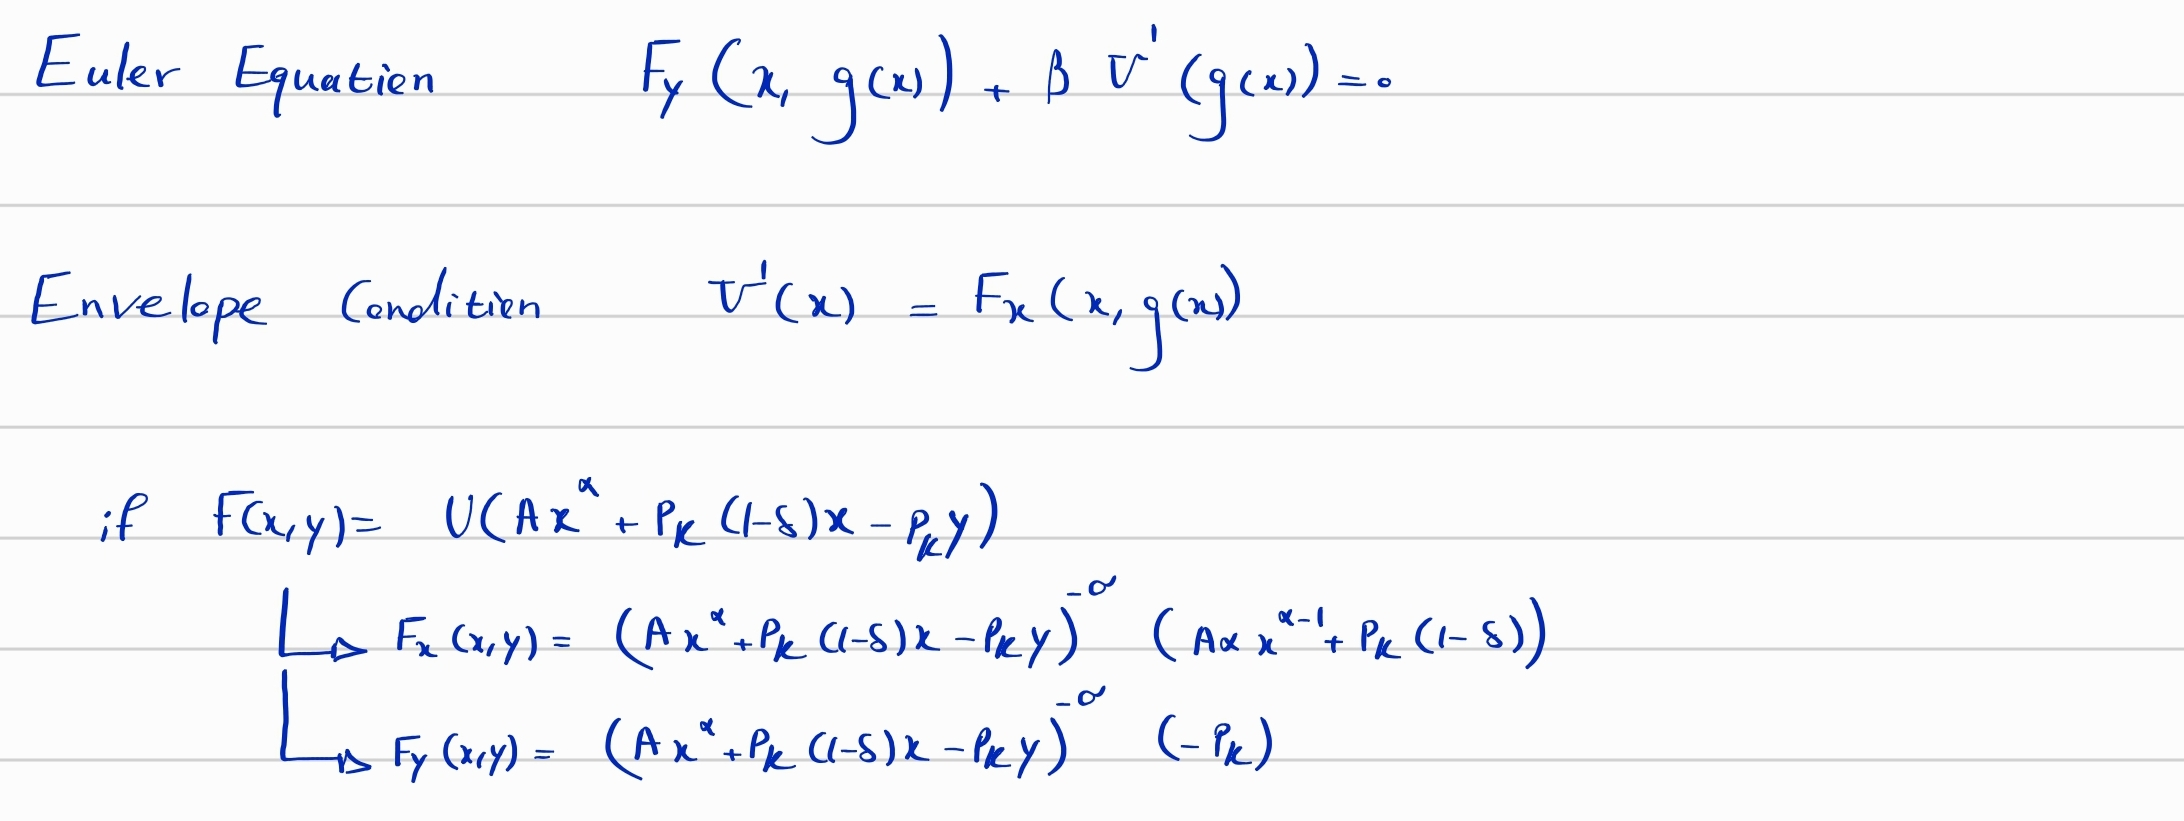

In [1]:
from joblib import Parallel, delayed
import numpy as np
from numpy import interp
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm

In [2]:
# Euler Equ is "1 - delta + alpha * A * K_t ** (alpha - 1) / P_k = (C_t / C_t_pre) ** sigma
alpha, delta, A, p_k, beta, sigma = 0.3, 0.05, 1.0, 1.0, 0.9, 0.5
k_ss = fsolve(func=lambda x: beta * (1 - delta + alpha * A * x[0] ** (alpha - 1) / p_k) - 1, x0=np.array([0.1]))[0]

In [3]:
from numpy import array as np_array 
# Importing increases performance of Parallel!

F_x = lambda x, y: (A * x**alpha + p_k * (1-delta) * x - p_k * y)**(-sigma) * (A * alpha * x**(alpha-1) + p_k * (1-delta))
F_y = lambda x, y: (A * x**alpha + p_k * (1-delta) * x - p_k * y)**(-sigma) * (-p_k)
T = lambda x: A * x ** alpha / p_k + (1 - delta) * x


def policy_func_iterate(x_grid, g_grid_0):
    # x=x in lambda!
    # Evaluation Time
    # https://realpython.com/python-lambda/
    v_prime_grid = F_x(x_grid, g_grid_0)
    g_grid_1 = np_array(Parallel(n_jobs=n_jobs, verbose=0, return_as='list', batch_size=grid_size // n_jobs)(
        delayed(fsolve)(func=(lambda g, x=x_grid[i]: F_y(x, g) + beta * interp(g, x_grid, v_prime_grid)), x0=g_grid_0[i]) for i in range(grid_size))).reshape(-1)
    g_grid_1 = np.min([g_grid_1, T(x_grid)], axis=0)
    g_grid_1 = np.max([g_grid_1, np.zeros(grid_size)], axis=0)
    return g_grid_1

## Signle Core

In [4]:
%%time

n_jobs = 1
grid_size = 10_000
current_k_grid = np.linspace(10**-6, 2 * k_ss, grid_size)
next_k_grid = np.linspace(10**-6, 2 * k_ss, grid_size)

max_iter = 1_000
tol = 10 ** -5
for _ in tqdm.tqdm(range(max_iter), ncols=100):
    g = policy_func_iterate(x_grid=current_k_grid, g_grid_0=next_k_grid)
    err = np.max(np.abs(g - next_k_grid))
    next_k_grid = g
    if err < tol:
        break
current_c_grid = A * current_k_grid ** alpha + p_k * (1 - delta) * current_k_grid - p_k * next_k_grid

print(f'Solved K_ss ({k_ss}) vs Found K_ss ({current_k_grid[np.argmin(np.abs(current_k_grid[1:] - next_k_grid[1:])) + 1]})')

  2%|█                                                            | 18/1000 [00:14<13:09,  1.24it/s]

Solved K_ss (2.430570549152421) vs Found K_ss (2.430327967839375)
CPU times: user 14.4 s, sys: 618 ms, total: 15 s
Wall time: 14.5 s


## Multi Core

In [5]:
%%time

n_jobs = 14
grid_size = 10_000
current_k_grid = np.linspace(10**-6, 2 * k_ss, grid_size)
next_k_grid = np.linspace(10**-6, 2 * k_ss, grid_size)

max_iter = 1_000
tol = 10 ** -5
for _ in tqdm.tqdm(range(max_iter), ncols=100):
    g = policy_func_iterate(x_grid=current_k_grid, g_grid_0=next_k_grid)
    err = np.max(np.abs(g - next_k_grid))
    next_k_grid = g
    if err < tol:
        break
current_c_grid = A * current_k_grid ** alpha + p_k * (1 - delta) * current_k_grid - p_k * next_k_grid

print(f'Solved K_ss ({k_ss}) vs Found K_ss ({current_k_grid[np.argmin(np.abs(current_k_grid[1:] - next_k_grid[1:])) + 1]})')

  2%|█                                                            | 18/1000 [00:08<07:28,  2.19it/s]

Solved K_ss (2.430570549152421) vs Found K_ss (2.430327967839375)
CPU times: user 7.2 s, sys: 638 ms, total: 7.84 s
Wall time: 8.23 s


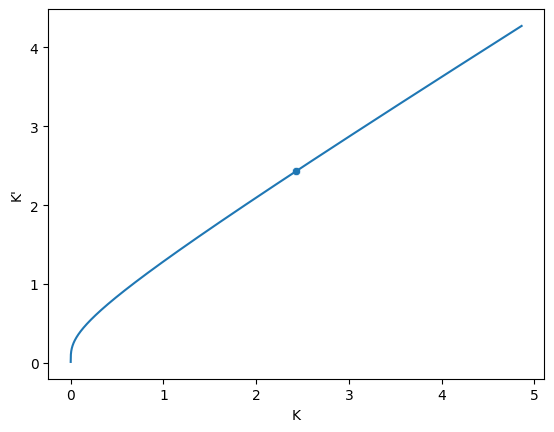

In [6]:
sns.lineplot(x=current_k_grid, y=next_k_grid)
sns.scatterplot(x=[current_k_grid[grid_size//2]], y=[next_k_grid[grid_size//2]])
plt.xlabel('K')
plt.ylabel("K'");